In [2]:
import sqlite3
import csv
from datetime import datetime
import time
import pandas as pd
import pyarrow.csv as pv
import pyarrow.parquet as pq
import pyarrow as pa
import polars as pl
import duckdb

In [ ]:
canvas = pd.read_csv('/content/drive/MyDrive/2022_place_canvas_history.csv')

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
csv_file = "/content/drive/MyDrive/2022_place_canvas_history.csv"
parquet_file = "2022pyarrow.parquet"

DATESTRING_FORMAT = "%Y-%m-%d %H:%M:%S"
BLOCK_SIZE = 100_000_000

read_options = pv.ReadOptions(block_size=BLOCK_SIZE)
csv_reader = pv.open_csv(csv_file, read_options=read_options)

parquet_writer = None
user_id_map = {}
next_user_id = 0

try:
    for record_batch in csv_reader:
        print(f"Processing batch with {record_batch.num_rows} rows...")

        df = pl.from_arrow(record_batch)

        df = df.with_columns(
            pl.col("timestamp")
            .str.replace(r" UTC$", "")
            .str.strptime(
                pl.Datetime,
                format="%Y-%m-%d %H:%M:%S%.f",
                strict=False
            )
            .alias("timestamp")
        )

        df = (
            df.filter(
                pl.col("coordinate").str.count_matches(",") == 1
            )
            .with_columns(
                pl.col("coordinate")
                .str.split_exact(",", 1)
                .struct.field("field_0")
                .cast(pl.Int64)
                .alias("x"),
                pl.col("coordinate")
                .str.split_exact(",", 1)
                .struct.field("field_1")
                .cast(pl.Int64)
                .alias("y"),
            )
            .drop("coordinate")
            )

        for uid in df["user_id"].unique():
            if uid not in user_id_map:
                user_id_map[uid] = len(user_id_map)

        # Replace user_id column with mapped values
        df = df.with_columns(
        pl.col("user_id").replace(user_id_map).alias("user_id")
          )
        table = df.to_arrow()

        if parquet_writer is None:
            parquet_writer = pq.ParquetWriter(
                parquet_file,
                schema=table.schema,
                compression="zstd"
            )
        parquet_writer.write_table(table)

finally:
    if parquet_writer:
        parquet_writer.close()

print(f"Successfully converted {csv_file} to {parquet_file}")

Processing batch with 735533 rows...


KeyboardInterrupt: 

In [3]:
parquet_file = pq.ParquetFile("/content/drive/MyDrive/2022pyarrow.parquet")

for i in parquet_file.iter_batches(batch_size=1000):
    print("RecordBatch")
    print(i.to_pandas())

RecordBatch
                  timestamp user_id pixel_color     x     y
0   2022-04-04 00:53:51.577  194001     #00CCC0   826  1048
1   2022-04-04 00:53:53.758  124824     #94B3FF   583  1031
2   2022-04-04 00:53:54.685  268698     #6A5CFF  1873   558
3   2022-04-04 00:54:57.541  119473     #009EAA  1627   255
4   2022-04-04 00:55:16.307  130068     #94B3FF    49  1478
..                      ...     ...         ...   ...   ...
995 2022-04-04 01:42:45.274   92449     #94B3FF   360  1700
996 2022-04-04 01:42:47.359   20898     #00CCC0   480   435
997 2022-04-04 01:42:54.847  275272     #E4ABFF  1278  1938
998 2022-04-04 01:43:01.883  424981     #94B3FF  1405  1571
999 2022-04-04 01:43:13.550  230896     #00CCC0   833  1058

[1000 rows x 5 columns]
RecordBatch
                  timestamp user_id pixel_color     x     y
0   2022-04-04 01:43:35.343  443611     #00CCC0   256  1526
1   2022-04-04 01:44:19.358   75134     #94B3FF  1920  1211
2   2022-04-04 01:44:21.842  146120     #E4ABFF  18

KeyboardInterrupt: 

In [6]:

parquet_file = "/content/drive/MyDrive/2022pyarrow.parquet"
def database(db_name, data):
    conn = duckdb.connect(db_name)

    conn.execute(f'''
        CREATE TABLE IF NOT EXISTS "{db_name}" (
            timestamp TEXT,
            user_id TEXT,
            pixel_color TEXT,
            coordinate_x INTEGER,
            coordinate_y INTEGER
        )
    ''')

    conn.execute(f'''
            INSERT INTO "{db_name}"
            SELECT * FROM read_parquet(?);
        ''', [data])

    conn.close()

database("rplace", parquet_file)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [ ]:
def query_data(db_name, start, end):
    # Connect to DuckDB
    conn = duckdb.connect(db_name)

    most_locations = conn.execute(f'''
        SELECT coordinate_x, coordinate_y, COUNT(user_id) AS distinct_count
        FROM "{db_name}"
        WHERE timestamp BETWEEN '{start}' AND '{end}'
        GROUP BY coordinate_x, coordinate_y
        ORDER BY distinct_count DESC
        LIMIT 5
    ''', ).fetchall()


    conn.close()
    return most_locations

# MAIN
name = 'rplace'

start = "2022-04-01 12:00:00"
end = "2022-04-05 23:59:59"

start_time = time.perf_counter_ns()

result = query_data(name, start, end)

end_time = time.perf_counter_ns()



FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [ ]:
print(f"Most placed colors: {result}")
print(f"Execution time: {(end_time - start_time)/ 1e9} seconds")

Most placed colors: [(0, 0, 98807), (359, 564, 69198), (349, 564, 55230), (859, 766, 52261), (860, 766, 51485)]
Execution time: 40.155764648 seconds


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

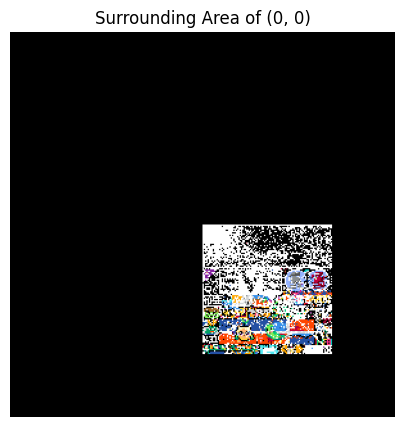

<ipython-input-7-8d599b3f9823>:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(colors), y=list(counts), palette=hex_colors, edgecolor='black')


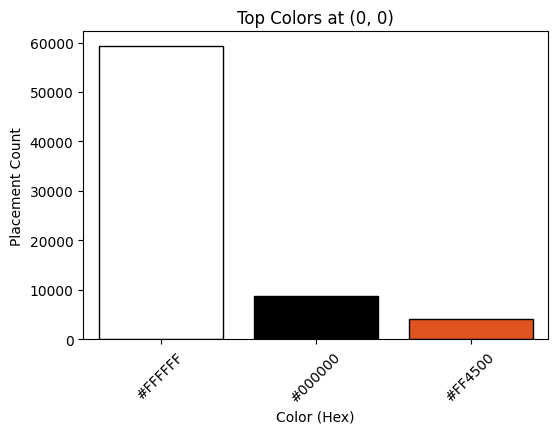

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

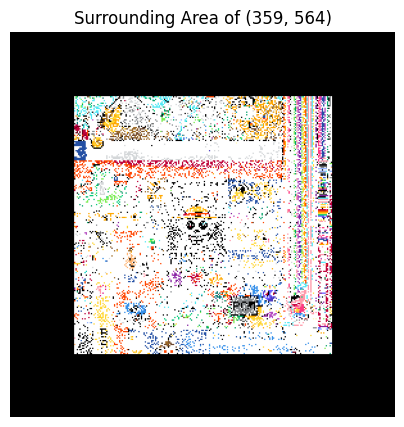

<ipython-input-7-8d599b3f9823>:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(colors), y=list(counts), palette=hex_colors, edgecolor='black')


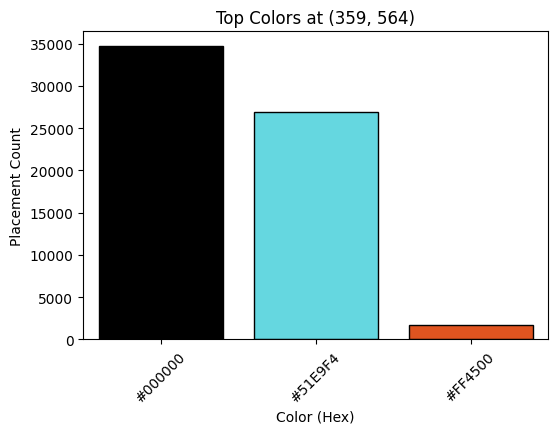

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

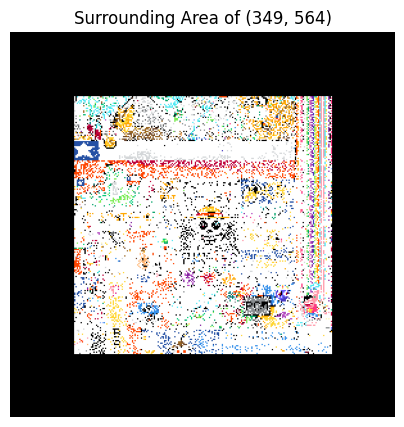

<ipython-input-7-8d599b3f9823>:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(colors), y=list(counts), palette=hex_colors, edgecolor='black')


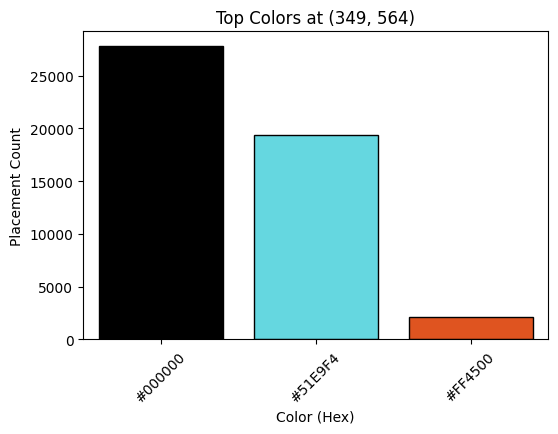

In [7]:
import duckdb
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import Counter

def get_surrounding_pixels(db_name, x, y, radius=100):
    """Fetches pixel data for a small area surrounding a given coordinate."""
    conn = duckdb.connect(db_name)
    query = f'''
        SELECT coordinate_x, coordinate_y, pixel_color
        FROM "{db_name}"
        WHERE coordinate_x BETWEEN {x - radius} AND {x + radius}
        AND coordinate_y BETWEEN {y - radius} AND {y + radius}
    '''
    result = conn.execute(query).fetchall()
    conn.close()
    return result

def plot_surrounding_area(pixel_data, x, y):
    """Plots a small map of the area surrounding the given pixel."""
    if not pixel_data:
        print("No data found for surrounding pixels.")
        return
    # RGB color map
    grid_size = max([abs(px[0] - x) for px in pixel_data] + [abs(px[1] - y) for px in pixel_data]) * 2 + 100
    pixel_map = np.zeros((grid_size, grid_size, 3))

    for px, py, color in pixel_data:
        grid_x, grid_y = px - (x - grid_size//2), py - (y - grid_size//2)
        clean_color = color.lstrip('#')
        if len(clean_color) == 6:
            pixel_map[grid_y, grid_x] = [int(clean_color[i:i+2], 16)/255 for i in (0, 2, 4)]


    plt.figure(figsize=(5, 5))
    plt.imshow(pixel_map)
    plt.title(f"Surrounding Area of ({x}, {y})")
    plt.axis("off")
    plt.show()

def get_top_colors(db_name, x, y, top_n=3):
    """Fetches the top N most frequently placed colors at a given pixel."""
    conn = duckdb.connect(db_name)
    query = f'''
        SELECT pixel_color, COUNT(*) as count
        FROM "{db_name}"
        WHERE coordinate_x = {x} AND coordinate_y = {y}
        GROUP BY pixel_color
        ORDER BY count DESC
        LIMIT {top_n}
    '''
    result = conn.execute(query).fetchall()
    conn.close()
    return result

def plot_top_colors(color_data, x, y):
    """Plots a bar chart of the top colors at a given pixel."""
    colors, counts = zip(*color_data)
    hex_colors = [f'{c}' for c in colors]

    plt.figure(figsize=(6, 4))
    sns.barplot(x=list(colors), y=list(counts), palette=hex_colors, edgecolor='black')
    plt.xlabel("Color (Hex)")
    plt.ylabel("Placement Count")
    plt.title(f"Top Colors at ({x}, {y})")
    plt.xticks(rotation=45)

    plt.show()



# MAIN
db_name = "rplace"
top_pixels = [(0, 0), (359, 564), (349, 564)]

for x, y in top_pixels:
    surrounding_pixels = get_surrounding_pixels(db_name, x, y)
    plot_surrounding_area(surrounding_pixels, x, y)

    top_colors = get_top_colors(db_name, x, y)
    plot_top_colors(top_colors, x, y)
